<a href="https://colab.research.google.com/github/balu337/Gesture-Recognition/blob/main/SubmissionFile_GestrueRecProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import zipfile
#from scipy.misc import imread, imresize
import datetime
import os

import imageio
import zipfile
import matplotlib.pyplot as plt
from itertools import chain

import datetime
import pytz

import keras.models as models
import keras.layers as layers
import keras.optimizers as optimizers

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,  Conv3D, MaxPooling3D, MaxPooling2D, Conv2D, LSTM, ConvLSTM2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the zip file

zip_file_path = '/content/drive/MyDrive/IITB_AIML/gProject/Project_data.zip' #'/content/drive/MyDrive/Keras/gProject/Project_data.zip'

# Extract the zip file into a directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('ges_dataset')

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
keras.utils.set_random_seed(30)
np.random.seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/ges_dataset/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/ges_dataset/Project_data/val.csv').readlines())
batch_size = 78 #39

In [ ]:
image_sequences=[0,2,4,6,8,10,12,14,16,18,20,24,26,28]
#image_sequences=[0,1,2,4,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,27,28,29]

x= len(image_sequences)
y, z = 100, 100

# Generic Functions

In [ ]:
def crop_img(img, scale=1.0):

    if img.shape[1] > img.shape[0]:
      diff_px = img.shape[1] - img.shape[0]
      crop_start = diff_px//2
      crop_end = crop_start + img.shape[0]
      img = img[:, crop_start:crop_end]
    elif img.shape[0] > img.shape[1]:
      diff_px = img.shape[0] - img.shape[1]
      crop_start = diff_px//2
      crop_end = crop_start + img.shape[1]
      img = img[:, crop_start:crop_end]
    return img

In [ ]:
def plotHistory(history):
  # summarize history for accuracy
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def printCurrentTime():
  now= datetime.datetime.now()
  # Specify IST timezone
  ist_timezone = pytz.timezone('Asia/Kolkata')

  # Convert to IST
  now_ist = now.astimezone(ist_timezone)

  print((now_ist).strftime("%c"))


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = image_sequences #List of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                # Check if enough images are available in the folder
                if len(imgs) < len(img_idx):
                    print(f"Warning: Folder {t[folder + (batch*batch_size)].split(';')[0]} has insufficient images. Skipping this folder.")
                    continue  # Skip this folder and move to the next


                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    crop_imp = crop_img(image, 0.1)
                    resized_im = tf.image.resize(crop_imp, [y, z])

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    crop_imp = crop_img(image, 0.1)
                    resized_im = tf.image.resize(crop_imp, [y, z])

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (resized_im[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_im[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_im[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/ges_dataset/Project_data/train'
val_path = '/content/ges_dataset/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


Source path =  /content/ges_dataset/Project_data/train ; batch size = 1


<ipython-input-11-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


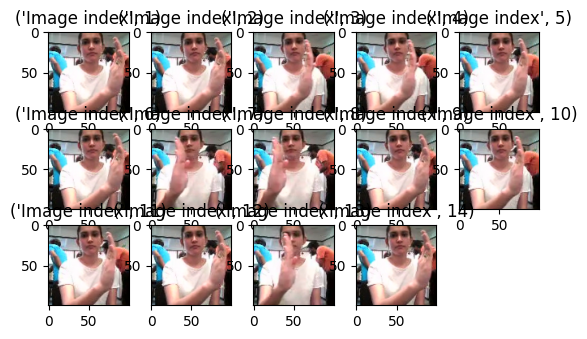

In [ ]:
# Check the generator
train_gen = generator(train_path, train_doc, 1)
d = next(train_gen)[0]

for i in range(d.shape[1]):
  plt.subplot(4, 5,  i+1)
  plt.title(f"{'Image index', i+1}")
  plt.imshow(d[0][i])

plt.show()

##Monika Generator

In [ ]:
# crop and rezise images
def crop_and_resize_img(img, scale=1.0, target_size=(64, 64)):
    # Step 1: Crop the image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]

    # Step 2: Resize the cropped image
    img_resized = cv2.resize(img_cropped, target_size, interpolation=cv2.INTER_AREA).astype(np.float32)
    # img_resized = cv2.resize(img_cropped,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

    return img_resized


In [ ]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size, x_dim, y_dim, img_idx):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    while True:
        t = np.random.permutation(folder_list)

# calculate the number of batches
        num_batches = int(len(t)/batch_size)

# we iterate over the number of batches
        for batch in range(num_batches):

# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,len(img_idx),x_dim,y_dim,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size
            for folder in range(batch_size):
# read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
#  Iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size Resizing the image 84,84
                    image = crop_and_resize_img(image, 0.03, (x_dim,y_dim))

#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels


# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),x_dim,y_dim,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

# Cropping image by 3 % of original size Resizing the image
                    image = crop_and_resize_img(image, 0.03, (x_dim,y_dim))

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
def call_generator_modified(batch_size,x_dim,y_dim,img_indexs):
  train_generator = generator_modified(train_path, train_doc, batch_size,x_dim,y_dim,img_indexs)
  val_generator = generator_modified(val_path, val_doc, batch_size,x_dim,y_dim,img_indexs)

  return train_generator, val_generator

In [ ]:
def set_model_dir_checkpoint():
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
  if not os.path.exists(model_name):
      os.mkdir(model_name)
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
  # period variable is replaced by save_freq where 'epoch' saves model at every epoch it could be a number also.
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
  # write the REducelronplateau code here
  LR = LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
  callbacks_list = [checkpoint, LR]

  return callbacks_list

In [ ]:
def set_steps_per_epoch(batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  return steps_per_epoch, validation_steps

In [ ]:
# Plotting the result of Model 1 :
def plotting_history(history_model):
  # Plot the loss and accuracy curves for training and validation
    # summarize history for accuracy
    plt.plot(history_model.history['categorical_accuracy'])
    plt.plot(history_model.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Architecture 1 3D Convolutional Network, or Conv3D

## Model 1 - Base Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

*   Image size =100*100
*   10 epochs
*   image_sequences=[0;3;6,9,12,15,18,21,24,27]
*   Batch size = 30
*   learning rate .001

In [ ]:


input_shape = (x, y, z, 3)
#write your model here

model1 = Sequential()
model1.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model1.add(MaxPooling3D(pool_size=2))


model1.add(Conv3D(64, kernel_size=3, activation='relu'))
model1.add(MaxPooling3D(pool_size=2))


model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.001)  #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 8, 98, 98, 32)       │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 4, 49, 49, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 2, 47, 47, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 1, 23, 23, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,667,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,726,661 (33.29 MB)

 Trainable params: 8,726,661 (33.29 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

print( filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2025-01-0508_38_44.170193/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
import time

startTime = time.time()
print(startTime)
history=model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

endTime = time.time()



1736066375.4084818
Source path =  /content/ges_dataset/Project_data/train ; batch size = 39


<ipython-input-9-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
 7/17 ━━━━━━━━━━━━━━━━━━━━ 2:39 16s/step - categorical_accuracy: 0.2146 - loss: 3.8105

KeyboardInterrupt: 

In [ ]:
print( endTime-startTime)


2650.979790210724


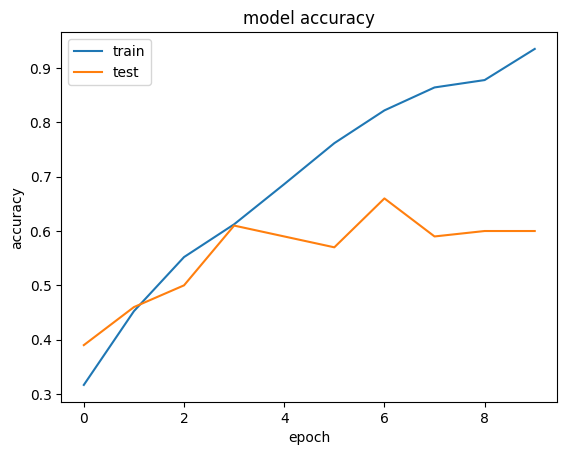

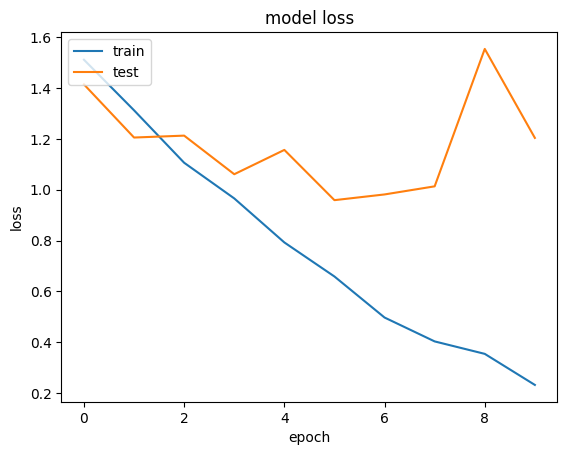

In [ ]:
plotHistory(history)

**Conclusion**
 From the plots above the gap between the Training and validation loss curves indicates Model is overfitting

Model 2

## Model2 - Adding more Layers

Adding One Layer to observe the model behaviour



*   Image size =100*100
*   10 epochs
*   image_sequences=[0;3;6,9,12,15,18,21,24,27]
*   Batch size = 30
*   learning rate .001


In [ ]:
image_sequences=[0,3,6,9,12,15,18,21,24,27]
batch_size = 30
x= len(image_sequences)
y, z = 100, 100


#write your model here

model2 = Sequential()
model2.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
model2.add(MaxPooling3D(pool_size=2))


model2.add(Conv3D(64, kernel_size=3, activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=2))

model2.add(Conv3D(128, kernel_size=3, activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=2))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.001)  #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_13 (Conv3D)                   │ (None, 10, 100, 100, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 5, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 5, 50, 50, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 2, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 2, 25, 25, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 1, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,999,429 (19.07 MB)

 Trainable params: 4,999,429 (19.07 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

print( filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2025-01-0418_44_24.649050/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:


startTime = time.time()
print(startTime)
history2=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

endTime = time.time()




1736020635.4606247
Source path =  /content/ges_dataset/Project_data/train ; batch size = 39


<ipython-input-27-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.2239 - loss: 1.7079 Source path =  /content/ges_dataset/Project_data/val ; batch size = 39


<ipython-input-27-e2688813b1d0>:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)



Epoch 1: saving model to model_init_2025-01-0418_44_24.649050/model-00001-1.62966-0.24284-1.52640-0.40000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 429s 25s/step - categorical_accuracy: 0.2250 - loss: 1.7036 - val_categorical_accuracy: 0.4000 - val_loss: 1.5264 - learning_rate: 0.0010
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - categorical_accuracy: 0.3788 - loss: 1.4664 
Epoch 2: saving model to model_init_2025-01-0418_44_24.649050/model-00002-1.42372-0.39367-1.21756-0.53000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 413s 24s/step - categorical_accuracy: 0.3797 - loss: 1.4640 - val_categorical_accuracy: 0.5300 - val_loss: 1.2176 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - categorical_accuracy: 0.4876 - loss: 1.2207 
Epoch 3: saving model to model_init_2025-01-0418_44_24.649050/model-00003-1.22721-0.48567-1.20370-0.48000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 412s 24s/step - categorical_accuracy: 0.4875 - loss: 1.2210 - val_categorical_accuracy: 0.4800 - val_loss: 1.203

In [ ]:
print( endTime-startTime)

4147.151545524597


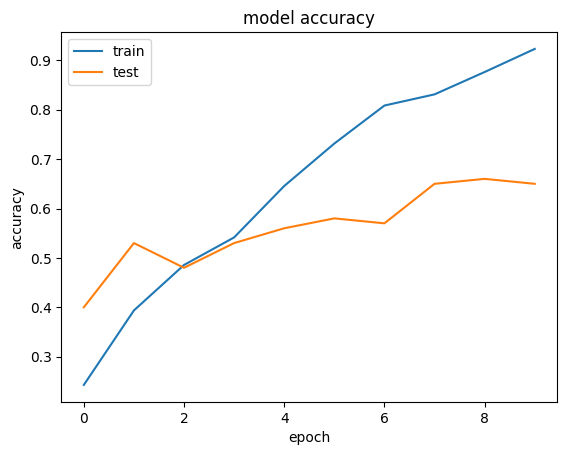

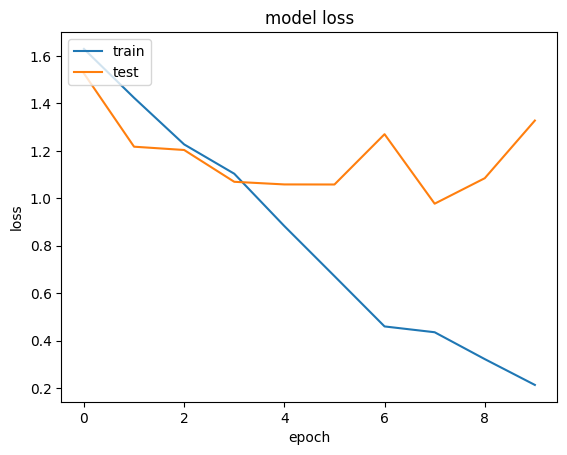

In [ ]:
plotHistory(history2)

In [ ]:
print("End")

End


## Model 3  - Adding Batch Normlaizaiton and Dropout

Adding Batch Normalization and drop out to handle overfitting
*   Image size =100*100
*   10 epochs
*   image_sequences=[0;3;6,9,12,15,18,21,24,27]
*   Batch size = 30
*   learning rate .001



In [ ]:
image_sequences=[0,3,6,9,12,15,18,21,24,27]
batch_size = 30
x= len(image_sequences)
y, z = 100, 100


input_shape = (x, y, z, 3)
#write your model here

model = Sequential()
model.add(Conv3D(32, kernel_size=3, input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))


model.add(Conv3D(64, kernel_size=3,  activation='relu', padding='same'))
model.add( BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(128, kernel_size=3,  activation='relu', padding='same'))
model.add( BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))


model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.001)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 19, 100, 100, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 19, 100, 100, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 19, 100, 100, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 9, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 9, 50, 50, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 50, 50, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 9, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 4, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 4, 25, 25, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 25, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,718,917 (37.07 MB)

 Trainable params: 9,718,469 (37.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

print( filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2025-01-0509_22_41.673678/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
import time

startTime = time.time()
print(startTime)
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

endTime = time.time()




1736068965.503048
Source path =  /content/ges_dataset/Project_data/train ; batch size = 39


<ipython-input-17-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2880 - loss: 30.7499Source path =  /content/ges_dataset/Project_data/val ; batch size = 39


<ipython-input-17-e2688813b1d0>:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)



Epoch 1: saving model to model_init_2025-01-0509_22_41.673678/model-00001-22.21769-0.31825-17.89211-0.19000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - categorical_accuracy: 0.2897 - loss: 30.2759 - val_categorical_accuracy: 0.1900 - val_loss: 17.8921 - learning_rate: 0.0010
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4561 - loss: 2.3708
Epoch 2: saving model to model_init_2025-01-0509_22_41.673678/model-00002-1.97581-0.47662-6.30680-0.18000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - categorical_accuracy: 0.4573 - loss: 2.3489 - val_categorical_accuracy: 0.1800 - val_loss: 6.3068 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5966 - loss: 1.0730
Epoch 3: saving model to model_init_2025-01-0509_22_41.673678/model-00003-1.01729-0.61388-3.25698-0.24000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - categorical_accuracy: 0.5975 - loss: 1.0699 - val_categorical_accuracy: 0.2400 - val_loss: 3.2570 - l

In [ ]:
print( endTime-startTime)


970.3912982940674


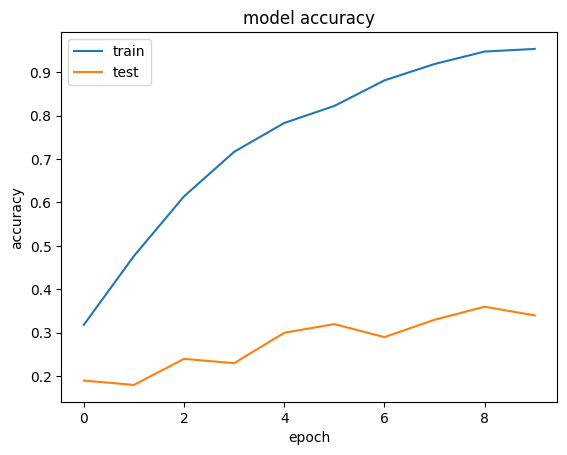

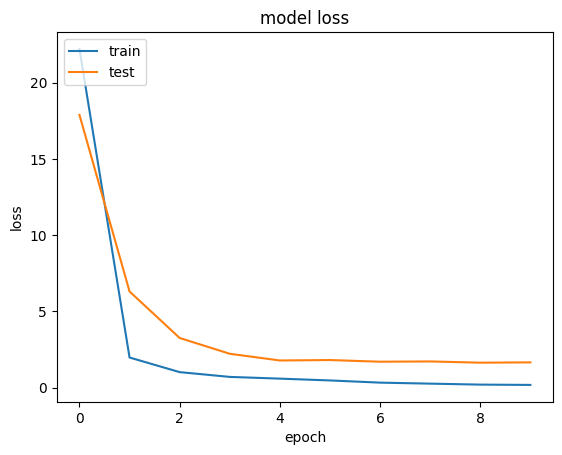

In [ ]:
plotHistory(history)

In [ ]:
print("End")

End


## Model 4 - model 11  - Batch Size Change and Images

Increase Number of images and Batch size

*   Adding One Layer to observe the model behaviour
*   Image size =100*100
*   10 epochs
*   image_sequences=[0,2,4,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
*   Batch size = 39
*   learning rate .001


In [ ]:


image_sequences=[0,2,4,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
batch_size = 39
x= len(image_sequences)
y, z = 100, 100


input_shape = (x, y, z, 3)
#write your model here

model = Sequential()
model.add(Conv3D(32, kernel_size=3, input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))


model.add(Conv3D(64, kernel_size=3,  activation='relu', padding='same'))
model.add( BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(128, kernel_size=3,  activation='relu', padding='same'))
model.add( BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))


model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.001)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 19, 100, 100, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 19, 100, 100, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 19, 100, 100, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 9, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 9, 50, 50, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 50, 50, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 9, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 4, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 4, 25, 25, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 25, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,718,917 (37.07 MB)

 Trainable params: 9,718,469 (37.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

print( filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2025-01-0516_08_35.509510/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
import time

startTime = time.time()
print(startTime)
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

endTime = time.time()




1736093320.724494
Source path =  /content/ges_dataset/Project_data/train ; batch size = 78


<ipython-input-9-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
7/9 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - categorical_accuracy: 0.2090 - loss: 50.4320

<ipython-input-9-e2688813b1d0>:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.2105 - loss: 47.6743Source path =  /content/ges_dataset/Project_data/val ; batch size = 78

Epoch 1: saving model to model_init_2025-01-0516_08_35.509510/model-00001-37.26290-0.22172-50.61223-0.18000.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - categorical_accuracy: 0.2116 - loss: 46.6332 - val_categorical_accuracy: 0.1800 - val_loss: 50.6122 - learning_rate: 0.0010
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.3728 - loss: 8.0792 
Epoch 2: saving model to model_init_2025-01-0516_08_35.509510/model-00002-6.66439-0.37406-26.52624-0.18000.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - categorical_accuracy: 0.3729 - loss: 7.9377 - val_categorical_accuracy: 0.1800 - val_loss: 26.5262 - learning_rate: 0.0010
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.4885 - loss: 3.9116 
Epoch 3: saving model to model_init_2025-01-0516_08_35.509510/model-00003-3.48060-0.50226-13.33593-0.

In [ ]:
print( endTime-startTime)


962.9337613582611


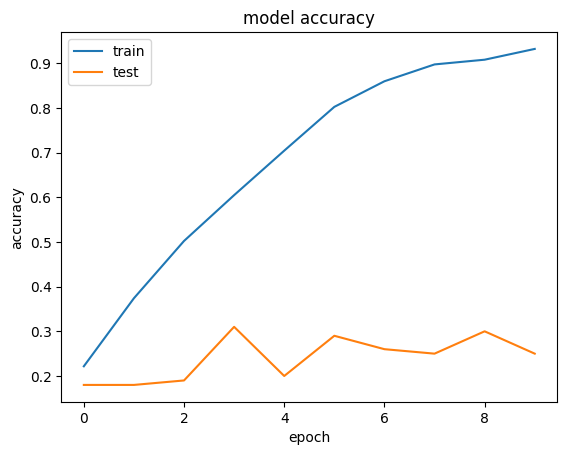

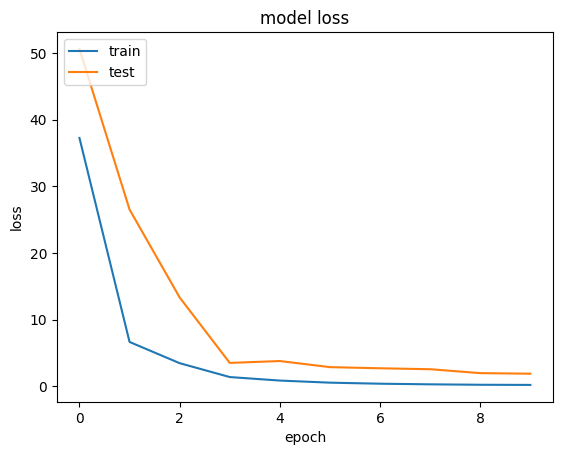

In [ ]:
plotHistory(history)

In [ ]:
print("End")

End


## Model5-  Conv3D -Increase dropput rate to .3

Increase dropout rate from .2 to .3

In [ ]:
#(len(image_sequences), imagex ,image y,3)

input_shape = (x, y, z, 3)
#write your model here

model = Sequential()
model.add(Conv3D(32, kernel_size=3, input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))


model.add(Conv3D(64, kernel_size=3,  activation='relu', padding='same'))
model.add( BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(128, kernel_size=3,  activation='relu', padding='same'))
model.add( BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=2))


model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.001)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 14, 100, 100, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 100, 100, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 14, 100, 100, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 7, 50, 50, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 50, 50, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 7, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 3, 25, 25, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 25, 25, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 3, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 1, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,000,325 (19.07 MB)

 Trainable params: 4,999,877 (19.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

print( filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2025-01-0711_41_38.138761/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
import time

startTime = time.time()
print(startTime)
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

endTime = time.time()




1736250992.8701503


<ipython-input-11-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
3/9 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - categorical_accuracy: 0.5036 - loss: 1.0440  

<ipython-input-11-e2688813b1d0>:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5619 - loss: 1.0127
Epoch 1: saving model to model_init_2025-01-0711_41_38.138761/model-00001-0.96783-0.61388-1.83553-0.18000.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - categorical_accuracy: 0.5671 - loss: 1.0082 - val_categorical_accuracy: 0.1800 - val_loss: 1.8355 - learning_rate: 0.0010
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.6482 - loss: 0.8544
Epoch 2: saving model to model_init_2025-01-0711_41_38.138761/model-00002-0.87486-0.63801-1.73950-0.17000.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - categorical_accuracy: 0.6472 - loss: 0.8565 - val_categorical_accuracy: 0.1700 - val_loss: 1.7395 - learning_rate: 0.0010
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.7002 - loss: 0.8038
Epoch 3: saving model to model_init_2025-01-0711_41_38.138761/model-00003-0.75659-0.71041-1.56133-0.24000.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - categorical_accuracy: 0.7012 - loss

In [ ]:
print( endTime-startTime)


743.1568503379822


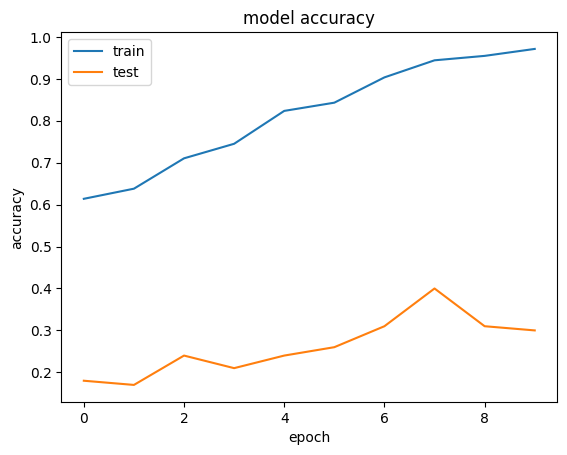

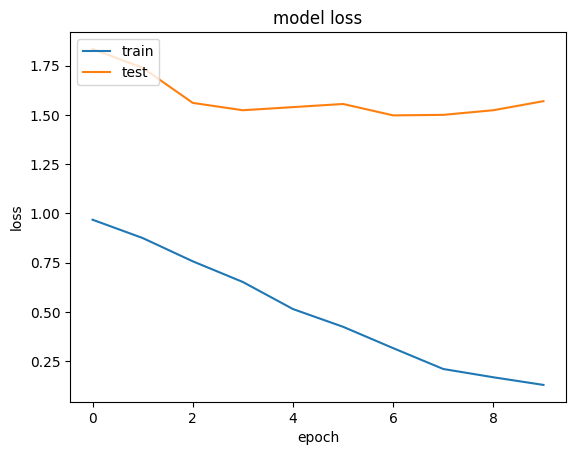

In [ ]:
plotHistory(history)

In [ ]:
printCurrentTime()

## Model 6 Conv3D

- 15 epochs and 50 batch size
- image size increased to 100X100
- Reduced the learning rate to 0.001
- reduce the params by reducing layers in model
- Global Average Pooling instead of Flatten
- check with early stop callback


In [ ]:
num_epochs = 15
print ('# epochs =', num_epochs)

batch_size = 50
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [0,3,6,9,11,13,15,17,20,23,25,27,29]
print(len(img_indexs))

# epochs = 15
# batch_size = 50
13


In [ ]:
modelConv3D_4 = Sequential()

# First Conv3D Layer
modelConv3D_4.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(13, 100, 100, 3)))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_4.add(Dropout(0.25))  # Slightly lower dropout

# Second Conv3D Layer
modelConv3D_4.add(Conv3D(16, (3, 3, 3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_4.add(Dropout(0.25))

# Third Conv3D Layer
modelConv3D_4.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_4.add(Dropout(0.3))

# Fourth Conv3D Layer
modelConv3D_4.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
modelConv3D_4.add(Dropout(0.3))

# Global Average Pooling instead of Flatten
modelConv3D_4.add(GlobalAveragePooling3D())

# Fully Connected Layers
modelConv3D_4.add(Dense(64, activation='relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Dropout(0.4))

# Output Layer
modelConv3D_4.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_con3d_4 = optimizers.Adam(learning_rate=0.001)

# Compile the model
modelConv3D_4.compile(
    optimizer=optimiser_con3d_4,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)


In [ ]:
# Print the model summary :
print (modelConv3D_4.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 13, 100, 100, 8)     │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 13, 100, 100, 8)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 13, 100, 100, 8)     │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 6, 50, 50, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 50, 50, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 6, 50, 50, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 6, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 6, 50, 50, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 3, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 3, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 3, 25, 25, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 3, 25, 25, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_14 (MaxPooling3D)      │ (None, 1, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 1, 12, 12, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 1, 12, 12, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_15 (MaxPooling3D)      │ (None, 1, 6, 6, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,197 (305.46 KB)

 Non-trainable params: 368 (1.44 KB)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,100,100,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
callbacks_list.append(early_stopping)

In [ ]:
history_con3d_4 = modelConv3D_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 50
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 77s/step - categorical_accuracy: 0.2482 - loss: 2.2252  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2025-01-0409_13_26.676958/model-00001-2.09750-0.24887-1.62166-0.22000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1219s 92s/step - categorical_accuracy: 0.2482 - loss: 2.2167 - val_categorical_accuracy: 0.2200 - val_loss: 1.6217 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - categorical_accuracy: 0.2509 - loss: 1.9730 
Epoch 2: saving model to model_init_2025-01-0409_13_26.676958/model-00002-1.91008-0.26998-1.64697-0.22000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 250s 18s/step - categorical_accuracy: 0.2522 - loss: 1.9688 - val_categorical_accuracy: 0.2200 - val_loss: 1.6470 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - categorical_accuracy: 0.2989 - loss: 1.8939 
Epo

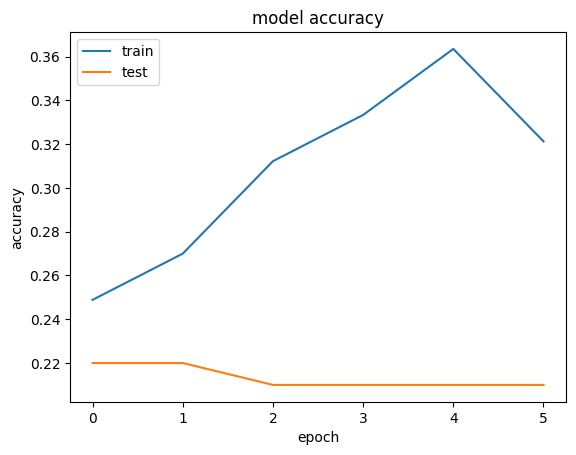

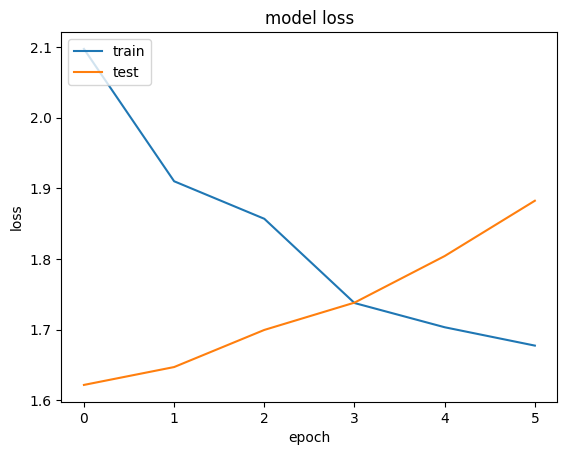

In [ ]:
plotting_history(history_con3d_4)

# Architecture 2 CNN + RNN Stack

## Model 7 Conv2D + LSTM model 1

- Epochs 8
- Batch Size 8
- Image frames as I/P 8
- 64*64 Image size
- Optimizer Adam learning_rate=0.0005

In [ ]:
num_epochs = 8
print ('# epochs =', num_epochs)

batch_size = 8
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 8
# batch_size = 8
8


In [ ]:
# Optimized Input Shape
input_shape = (8, 64, 64, 3)  # Reduced spatial dimensions to 64 to reduce computation.

cnn_lstm_1 = Sequential()

# First TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'),
                                       input_shape=input_shape))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))  # Pooling reduces computation

# Second TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# # Third TimeDistributed Conv2D Layer
# cnn_lstm_1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))  # Reduced filters
# cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
# cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten Layer
cnn_lstm_1.add(TimeDistributed(Flatten()))

# LSTM Layer
cnn_lstm_1.add(LSTM(64, return_sequences=False))  # Reduced LSTM units
cnn_lstm_1.add(Dropout(0.25))

# Fully Connected Layers
cnn_lstm_1.add(Dense(64, activation='relu'))  # Reduced dense units
cnn_lstm_1.add(Dropout(0.25))

# Output Layer
cnn_lstm_1.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_optimized = optimizers.Adam(learning_rate=0.0005)  # Higher learning rate to converge faster

# Compile Model
cnn_lstm_1.compile(optimizer=optimiser_optimized, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print(cnn_lstm_1.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 8, 64, 64, 8)        │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 64, 64, 8)        │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 8, 32, 32, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 8, 32, 32, 16)       │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 8, 32, 32, 16)       │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 8, 16, 16, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 8, 4096)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,065,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,071,189 (4.09 MB)

 Trainable params: 1,071,141 (4.09 MB)

 Non-trainable params: 48 (192.00 B)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_lstm_1 = cnn_lstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - categorical_accuracy: 0.2207 - loss: 1.6583 Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2025-01-0607_14_11.156559/model-00001-1.63764-0.24133-1.59815-0.28000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 2122s 26s/step - categorical_accuracy: 0.2210 - loss: 1.6581 - val_categorical_accuracy: 0.2800 - val_loss: 1.5982 - learning_rate: 5.0000e-04
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - categorical_accuracy: 0.2811 - loss: 1.5962
Epoch 2: saving model to model_init_2025-01-0607_14_11.156559/model-00002-1.59094-0.28205-1.57915-0.22000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 525ms/step - categorical_accuracy: 0.2811 - loss: 1.5962 - val_categorical_accuracy: 0.2200 - val_loss: 1.5792 - learning_rate: 5.0000e-04
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - categorical_accuracy: 0.3332 - loss: 1.540

In [ ]:
plotting_history(history_lstm_1)

## Model 8 Conv2D + LSTM model 2

- Added one more layers of Conv2D from previous iteration
- Epochs 10
- Batch Size 16
- Image frames as I/P 8
- 64*64 Image size
- Optimizer Adam learning_rate=0.0005

In [ ]:
num_epochs = 10
print ('# epochs =', num_epochs)

batch_size = 16
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 10
# batch_size = 16
8


In [ ]:
# Optimized Input Shape
input_shape = (8, 64, 64, 3)  # Reduced spatial dimensions to 64 to reduce computation.

cnn_lstm_1 = Sequential()

# First TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'),
                                       input_shape=input_shape))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))  # Pooling reduces computation

# Second TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Third TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten Layer
cnn_lstm_1.add(TimeDistributed(Flatten()))

# LSTM Layer
cnn_lstm_1.add(LSTM(64, return_sequences=False))  # Reduced LSTM units
cnn_lstm_1.add(Dropout(0.25))

# Fully Connected Layers
cnn_lstm_1.add(Dense(64, activation='relu'))  # Reduced dense units
cnn_lstm_1.add(Dropout(0.25))

# Output Layer
cnn_lstm_1.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_optimized = optimizers.Adam(learning_rate=0.0005)  # Higher learning rate to converge faster

# Compile Model
cnn_lstm_1.compile(optimizer=optimiser_optimized, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print(cnn_lstm_1.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 8, 64, 64, 8)        │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 64, 64, 8)        │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 8, 32, 32, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 8, 32, 32, 16)       │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 8, 32, 32, 16)       │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 8, 16, 16, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 8, 16, 16, 32)       │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 8, 16, 16, 32)       │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 8, 8, 8, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         540,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,669 (2.10 MB)

 Trainable params: 551,557 (2.10 MB)

 Non-trainable params: 112 (448.00 B)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_lstm_2 = cnn_lstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 16
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - categorical_accuracy: 0.2640 - loss: 1.6194  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_2025-01-0711_55_54.355570/model-00001-1.60509-0.28959-1.56490-0.29000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 2967s 72s/step - categorical_accuracy: 0.2646 - loss: 1.6191 - val_categorical_accuracy: 0.2900 - val_loss: 1.5649 - learning_rate: 5.0000e-04
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - categorical_accuracy: 0.3725 - loss: 1.5370
Epoch 2: saving model to model_init_2025-01-0711_55_54.355570/model-00002-1.56846-0.31976-1.53706-0.31000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - categorical_accuracy: 0.3713 - loss: 1.5377 - val_categorical_accuracy: 0.3100 - val_loss: 1.5371 - learning_rate: 5.0000e-04
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - categorical_accuracy: 0.3333 - loss: 1.

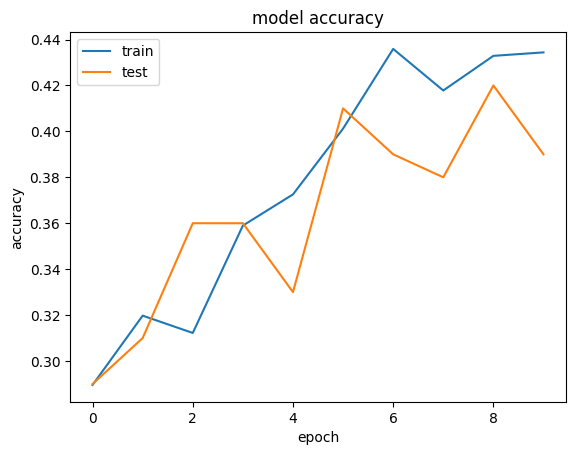

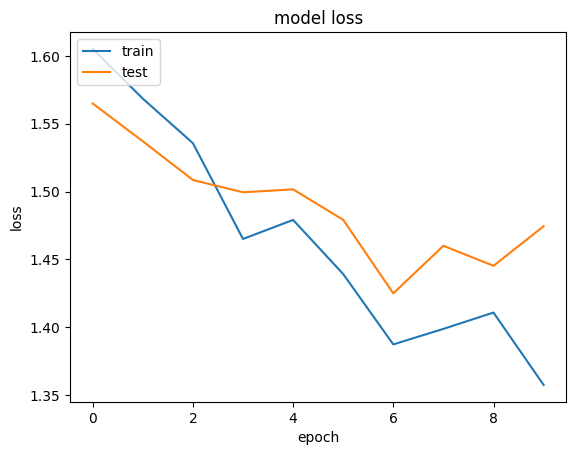

In [ ]:
plotting_history(history_lstm_2)

## Model 9 Conv2D - LSTM model 3
### Pending to run due to GPU limit exceed

In [ ]:
num_epochs = 10
print ('# epochs =', num_epochs)

batch_size = 16
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

In [ ]:
# Optimized Input Shape
input_shape = (8, 64, 64, 3)

cnn_lstm_optimized = Sequential()

# First TimeDistributed Conv2D Layer
cnn_lstm_optimized.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                       input_shape=input_shape))  # Increased filters
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Second TimeDistributed Conv2D Layer
cnn_lstm_optimized.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))  # Increased filters
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Third TimeDistributed Conv2D Layer
cnn_lstm_optimized.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))  # Increased filters
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Fourth TimeDistributed Conv2D Layer (New)
cnn_lstm_optimized.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))  # New Conv2D layer
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten Layer
cnn_lstm_optimized.add(TimeDistributed(Flatten()))

# LSTM Layer
cnn_lstm_optimized.add(LSTM(128, return_sequences=False))  # Increased LSTM units for better feature learning
cnn_lstm_optimized.add(Dropout(0.4))  # Slightly increased dropout for regularization

# Fully Connected Layers
cnn_lstm_optimized.add(Dense(128, activation='relu'))  # Increased dense units
cnn_lstm_optimized.add(BatchNormalization())  # Added BatchNormalization to dense layers
cnn_lstm_optimized.add(Dropout(0.4))

# Output Layer
cnn_lstm_optimized.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_optimized = optimizers.Adam(learning_rate=0.0001)  # Slightly reduced learning rate for stable training

# Compile Model
cnn_lstm_optimized.compile(optimizer=optimiser_optimized, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print(cnn_lstm_optimized.summary())


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_lstm_3 = cnn_lstm_optimized.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

## Model 10 Pre-trained model(ResNet 50) for Transfer learning

- Epochs 5
- Batch Size 4
- Image frames as I/P 8
- 64*64 Image size
- Optimizer Adam learning_rate=0.0001

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_3d_resnet(input_shape, num_classes):
    # Load pre-trained 2D ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[1], input_shape[2], input_shape[3]))

    # Freeze some layers of ResNet to leverage transfer learning
    for layer in base_model.layers[:-10]:  # Fine-tuning last 10 layers
        layer.trainable = False

    # Build model using TimeDistributed wrapper
    model = Sequential()
    model.add(TimeDistributed(base_model, input_shape=input_shape))  # Apply ResNet50 to each frame
    model.add(TimeDistributed(GlobalAveragePooling2D()))  # Pooling after applying ResNet50 to each frame
    model.add(LSTM(128))  # LSTM layer to process temporal information
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))  # Final classification layer

    return model

# Define model parameters
input_shape = (8, 64, 64, 3)  # 13 frames, 64x64 images, 3 channels (RGB)
num_classes = 5  # Number of gesture categories

# Build and compile the model
model_resnet = build_3d_resnet(input_shape, num_classes)
optimiser_resnet = optimizers.Adam(learning_rate=0.0001)
model_resnet.compile(optimizer=optimiser_resnet, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Display model summary
print(model_resnet.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_8 (TimeDistributed) │ (None, 8, 2, 2, 2048)       │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,719,493 (94.30 MB)

 Trainable params: 5,597,445 (21.35 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_resnet= model_resnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=callbacks_list,
    verbose=1
)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - categorical_accuracy: 0.2324 - loss: 1.6568Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2025-01-0510_42_33.411284/model-00001-1.64975-0.22624-1.61150-0.19000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 130s 434ms/step - categorical_accuracy: 0.2323 - loss: 1.6568 - val_categorical_accuracy: 0.1900 - val_loss: 1.6115 - learning_rate: 1.0000e-04
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - categorical_accuracy: 0.1884 - loss: 1.6256
Epoch 2: saving model to model_init_2025-01-0510_42_33.411284/model-00002-1.61955-0.21569-1.59207-0.17000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 334ms/step - categorical_accuracy: 0.1885 - loss: 1.6256 - val_categorical_accuracy: 0.1700 - val_loss: 1.5921 - learning_rate: 1.0000e-04
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - categorical_accuracy: 0.2762 -

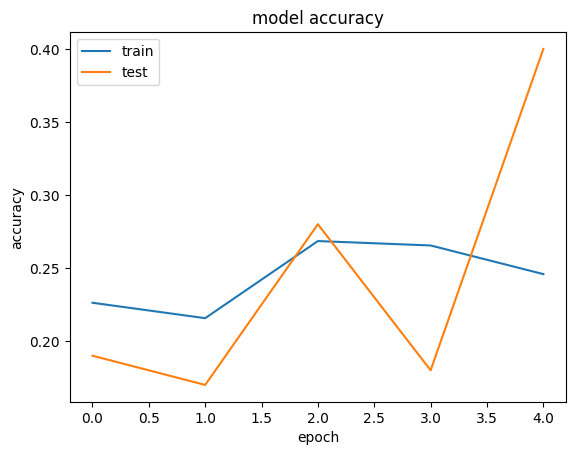

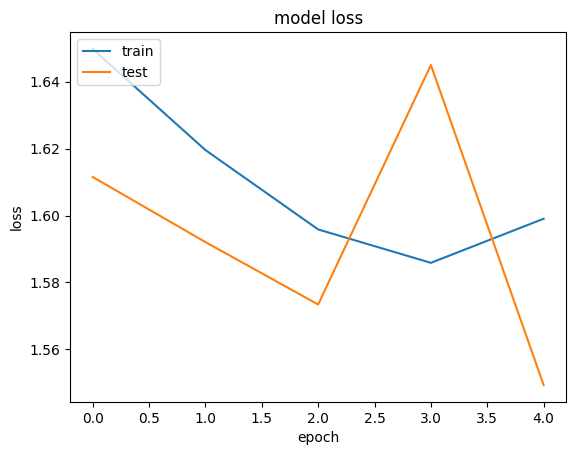

In [ ]:
plotting_history(history_resnet)

## Model 11 Pre-trained model 2(ResNet 50) for Transfer learning

- Epochs 8
- Batch Size 8
- Image frames as I/P 8
- 64*64 Image size
- Optimizer Adam learning_rate=0.0001

***No change in model so refrencing same model 12***



In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_resnet_updated= model_resnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=callbacks_list,
    verbose=1
)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - categorical_accuracy: 0.2299 - loss: 1.6278Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2025-01-0510_42_33.411284/model-00001-1.61633-0.26244-1.57956-0.23000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 119s 788ms/step - categorical_accuracy: 0.2303 - loss: 1.6277 - val_categorical_accuracy: 0.2300 - val_loss: 1.5796 - learning_rate: 1.0000e-04
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - categorical_accuracy: 0.2547 - loss: 1.5830
Epoch 2: saving model to model_init_2025-01-0510_42_33.411284/model-00002-1.57782-0.27903-1.52668-0.33000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 616ms/step - categorical_accuracy: 0.2550 - loss: 1.5829 - val_categorical_accuracy: 0.3300 - val_loss: 1.5267 - learning_rate: 1.0000e-04
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - categorical_accuracy: 0.2799 - loss: 1.5

## Model 12 - GRU Model


*  Image size =100*100
*  10 epochs
*  image_sequences=[0,2,4,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
*  Batch size = 39
*  learning rate .001


In [ ]:
image_sequences=[0,3,6,9,12,15,18,21,24,27]
batch_size = 39
x= len(image_sequences)
y, z = 100, 100
num_epochs = 10

input_shape = (x, y, z, 3)
#write your model here

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 19, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 19, 100, 100, 16)    │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 19, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 19, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 19, 50, 50, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 19, 25, 25, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 19, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 19, 25, 25, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 19, 12, 12, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 19, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 19, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 19, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 19, 4608)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │       1,819,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,934,949 (7.38 MB)

 Trainable params: 1,934,469 (7.38 MB)

 Non-trainable params: 480 (1.88 KB)

None


In [ ]:
model=GRU_lstm

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.001)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 19, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 19, 100, 100, 16)    │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 19, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 19, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 19, 50, 50, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 19, 25, 25, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 19, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 19, 25, 25, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 19, 12, 12, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 19, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 19, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 19, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 19, 4608)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │       1,819,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,934,949 (7.38 MB)

 Trainable params: 1,934,469 (7.38 MB)

 Non-trainable params: 480 (1.88 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

print( filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2025-01-0613_25_32.017085/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
import time

startTime = time.time()
print(startTime)
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

endTime = time.time()




1736169936.9664922
Source path =  /content/ges_dataset/Project_data/train ; batch size = 39


<ipython-input-10-e2688813b1d0>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2967 - loss: 1.7737Source path =  /content/ges_dataset/Project_data/val ; batch size = 39


<ipython-input-10-e2688813b1d0>:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)



Epoch 1: saving model to model_init_2025-01-0613_25_32.017085/model-00001-1.56846-0.36350-1.86211-0.32000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - categorical_accuracy: 0.3004 - loss: 1.7623 - val_categorical_accuracy: 0.3200 - val_loss: 1.8621 - learning_rate: 0.0010
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5138 - loss: 1.1693
Epoch 2: saving model to model_init_2025-01-0613_25_32.017085/model-00002-1.11397-0.54751-1.09465-0.62000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - categorical_accuracy: 0.5156 - loss: 1.1662 - val_categorical_accuracy: 0.6200 - val_loss: 1.0947 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.6372 - loss: 0.9625
Epoch 3: saving model to model_init_2025-01-0613_25_32.017085/model-00003-0.92202-0.63952-0.99053-0.63000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - categorical_accuracy: 0.6373 - loss: 0.9603 - val_categorical_accuracy: 0.6300 - val_loss: 0.9905 - lear

In [ ]:
print( endTime-startTime)


1027.9366672039032


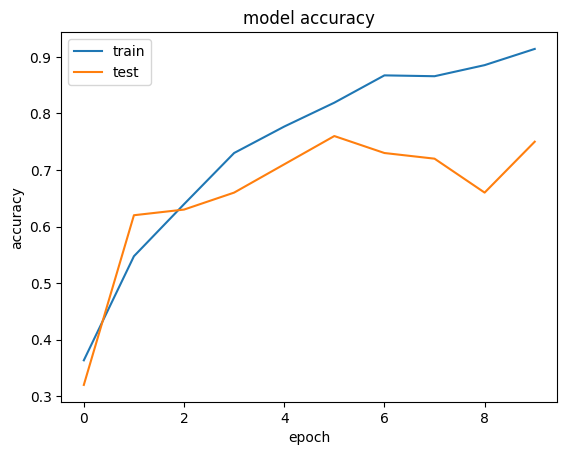

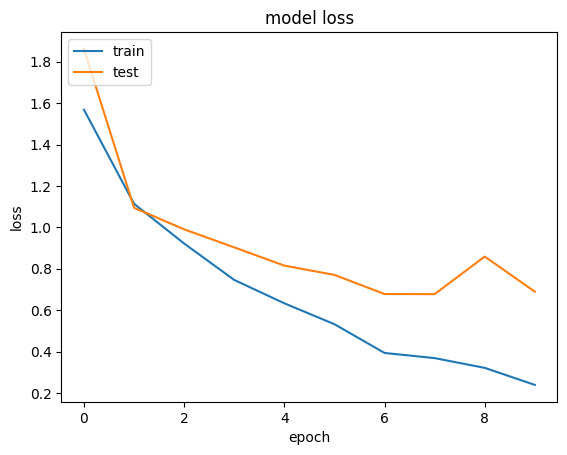

In [ ]:
plotHistory(history)

In [ ]:
printCurrentTime()

Mon Jan  6 19:12:45 2025
